# CycleGAN – Photo → Cartoon

• True cycle consistency
• Identity loss
• 50 epochs
• Loss visualization
• Inference after training


In [1]:
%pip install torch torchvision tqdm pillow matplotlib kaggle

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import matplotlib.pyplot as plt
os.environ['KAGGLE_USERNAME'] = 'YOUR_KAGGLE_USERNAME'
os.environ['KAGGLE_KEY'] = 'YOUR_KAGGLE_API_KEY'

In [10]:
!kaggle datasets download -d jessicali9530/celeba-dataset
!kaggle datasets download -d arnaud58/photo2cartoon
!unzip -q celeba-dataset.zip
!unzip -q photo2cartoon.zip

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset URL: https://www.kaggle.com/datasets/arnaud58/photo2cartoon
License(s): CC0-1.0
photo2cartoon.zip: Skipping, found more recently modified local copy (use --force to force download)


'unzip' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


## Dataset Preparation (SAFE)

In [3]:
import os
from PIL import Image
from tqdm import tqdm
import random

# Buat folder tujuan
os.makedirs('dataset/trainA', exist_ok=True)
os.makedirs('dataset/trainB', exist_ok=True)

# --- 1. PROSES REAL FACES (Target: 4000) ---
real_src = 'img_align_celeba'  # Pastikan path ini sesuai dengan folder hasil unzip kamu
output_real = 'dataset/trainA'
target_real = 4000

# Cek jumlah file yang sudah ada
current_real = len(os.listdir(output_real))

if current_real >= target_real:
    print(f"✅ Real faces sudah ada ({current_real} files). Skip processing.")
else:
    print(f"🔄 Memproses Real faces... (Target: {target_real})")
    real_imgs = os.listdir(real_src)
    
    # Ambil sample sejumlah target
    selected_real = random.sample(real_imgs, min(target_real, len(real_imgs)))
    
    for img in tqdm(selected_real, desc='Real faces'):
        try:
            # Cek apakah file sudah ada biar tidak ditimpa (opsional, tapi aman)
            dest_path = os.path.join(output_real, img)
            if not os.path.exists(dest_path):
                im = Image.open(os.path.join(real_src, img)).convert('RGB').resize((256, 256))
                im.save(dest_path)
        except Exception as e:
            pass # Skip jika ada gambar error

# --- 2. PROSES CARTOON FACES (Target: 3000) ---
cartoon_src = 'trainB'
output_cartoon = 'dataset/trainB'
target_cartoon = 3000

# Cek jumlah file yang sudah ada
current_cartoon = len(os.listdir(output_cartoon))

if current_cartoon >= target_cartoon:
    print(f"✅ Cartoon faces sudah ada ({current_cartoon} files). Skip processing.")
else:
    print(f"🔄 Memproses Cartoon faces... (Target: {target_cartoon})")
    cartoon_imgs = os.listdir(cartoon_src)
    
    # Ambil sample sejumlah target
    selected_cartoon = random.sample(cartoon_imgs, min(target_cartoon, len(cartoon_imgs)))
    
    for img in tqdm(selected_cartoon, desc='Cartoon faces'):
        try:
            dest_path = os.path.join(output_cartoon, img)
            if not os.path.exists(dest_path):
                im = Image.open(os.path.join(cartoon_src, img)).convert('RGB').resize((256, 256))
                im.save(dest_path)
        except Exception as e:
            pass

print("\n🎉 Dataset Preparation Selesai!")

✅ Real faces sudah ada (4000 files). Skip processing.
🔄 Memproses Cartoon faces... (Target: 3000)


Cartoon faces:   0%|          | 0/194 [00:00<?, ?it/s]

Cartoon faces: 100%|██████████| 194/194 [00:00<00:00, 9726.68it/s]


🎉 Dataset Preparation Selesai!


## Dataset Loader

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class UnpairedDataset(Dataset):
    def __init__(self, A, B):
        self.A = os.listdir(A)
        self.B = os.listdir(B)
        self.A_dir = A
        self.B_dir = B
        self.tf = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])
    def __len__(self): return max(len(self.A), len(self.B))
    def __getitem__(self, i):
        a = Image.open(os.path.join(self.A_dir, self.A[i % len(self.A)])).convert('RGB')
        b = Image.open(os.path.join(self.B_dir, random.choice(self.B))).convert('RGB')
        return self.tf(a), self.tf(b)

## CycleGAN Model (Correct Formulation)

In [5]:
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.b = nn.Sequential(
            nn.ReflectionPad2d(1), nn.Conv2d(c,c,3), nn.InstanceNorm2d(c), nn.ReLU(),
            nn.ReflectionPad2d(1), nn.Conv2d(c,c,3), nn.InstanceNorm2d(c)
        )
    def forward(self,x): return x + self.b(x)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [nn.ReflectionPad2d(3), nn.Conv2d(3,64,7), nn.InstanceNorm2d(64), nn.ReLU()]
        layers += [nn.Conv2d(64,128,3,2,1), nn.InstanceNorm2d(128), nn.ReLU()]
        layers += [nn.Conv2d(128,256,3,2,1), nn.InstanceNorm2d(256), nn.ReLU()]
        for _ in range(9): layers += [ResBlock(256)]
        layers += [nn.ConvTranspose2d(256,128,3,2,1,1), nn.InstanceNorm2d(128), nn.ReLU()]
        layers += [nn.ConvTranspose2d(128,64,3,2,1,1), nn.InstanceNorm2d(64), nn.ReLU()]
        layers += [nn.ReflectionPad2d(3), nn.Conv2d(64,3,7), nn.Tanh()]
        self.net = nn.Sequential(*layers)
    def forward(self,x): return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,64,4,2,1), nn.LeakyReLU(0.2),
            nn.Conv2d(64,128,4,2,1), nn.InstanceNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128,256,4,2,1), nn.InstanceNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256,1,4,1,1)
        )
    def forward(self,x): return self.net(x)

## Training – 50 Epochs


In [6]:
import os
import random
import torch
import torch.nn as nn
import itertools
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# --- 1. SETUP DEVICE ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚙️ Device: {device}")

# --- 2. DEFINISI DATASET (RESEP) ---
class UnpairedDataset(Dataset):
    def __init__(self, A, B):
        self.A = os.listdir(A)
        self.B = os.listdir(B)
        self.A_dir = A
        self.B_dir = B
        self.tf = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])
    def __len__(self): return max(len(self.A), len(self.B))
    def __getitem__(self, i):
        try:
            a = Image.open(os.path.join(self.A_dir, self.A[i % len(self.A)])).convert('RGB')
            b = Image.open(os.path.join(self.B_dir, random.choice(self.B))).convert('RGB')
            return self.tf(a), self.tf(b)
        except:
            # Fallback jika ada gambar rusak
            return self.__getitem__(i + 1)

# --- 3. DEFINISI MODEL (RESEP) ---
class ResBlock(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.b = nn.Sequential(
            nn.ReflectionPad2d(1), nn.Conv2d(c,c,3), nn.InstanceNorm2d(c), nn.ReLU(),
            nn.ReflectionPad2d(1), nn.Conv2d(c,c,3), nn.InstanceNorm2d(c)
        )
    def forward(self,x): return x + self.b(x)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [nn.ReflectionPad2d(3), nn.Conv2d(3,64,7), nn.InstanceNorm2d(64), nn.ReLU()]
        layers += [nn.Conv2d(64,128,3,2,1), nn.InstanceNorm2d(128), nn.ReLU()]
        layers += [nn.Conv2d(128,256,3,2,1), nn.InstanceNorm2d(256), nn.ReLU()]
        for _ in range(9): layers += [ResBlock(256)]
        layers += [nn.ConvTranspose2d(256,128,3,2,1,1), nn.InstanceNorm2d(128), nn.ReLU()]
        layers += [nn.ConvTranspose2d(128,64,3,2,1,1), nn.InstanceNorm2d(64), nn.ReLU()]
        layers += [nn.ReflectionPad2d(3), nn.Conv2d(64,3,7), nn.Tanh()]
        self.net = nn.Sequential(*layers)
    def forward(self,x): return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,64,4,2,1), nn.LeakyReLU(0.2),
            nn.Conv2d(64,128,4,2,1), nn.InstanceNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128,256,4,2,1), nn.InstanceNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256,1,4,1,1)
        )
    def forward(self,x): return self.net(x)

# --- 4. INISIALISASI (MASAK) ---
print("🍳 Sedang menyiapkan DataLoader dan Model...")

# Siapkan Data (Mengisi variable 'dl')
ds = UnpairedDataset('dataset/trainA', 'dataset/trainB')
dl = DataLoader(ds, batch_size=1, shuffle=True, pin_memory=True)

# Siapkan Model (Mengisi variable 'G_AB', dll)
G_AB = Generator().to(device)
G_BA = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

# Siapkan Optimizer
gan = nn.MSELoss()
cycle = nn.L1Loss()
identity = nn.L1Loss()
opt_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(itertools.chain(D_A.parameters(), D_B.parameters()), lr=0.0002, betas=(0.5, 0.999))

print("✅ SUKSES! Variable 'dl' dan 'G_AB' sudah siap.")
print("👉 Silakan langsung RUN cell Training di bawah ini.")

⚙️ Device: cuda
🍳 Sedang menyiapkan DataLoader dan Model...
✅ SUKSES! Variable 'dl' dan 'G_AB' sudah siap.
👉 Silakan langsung RUN cell Training di bawah ini.


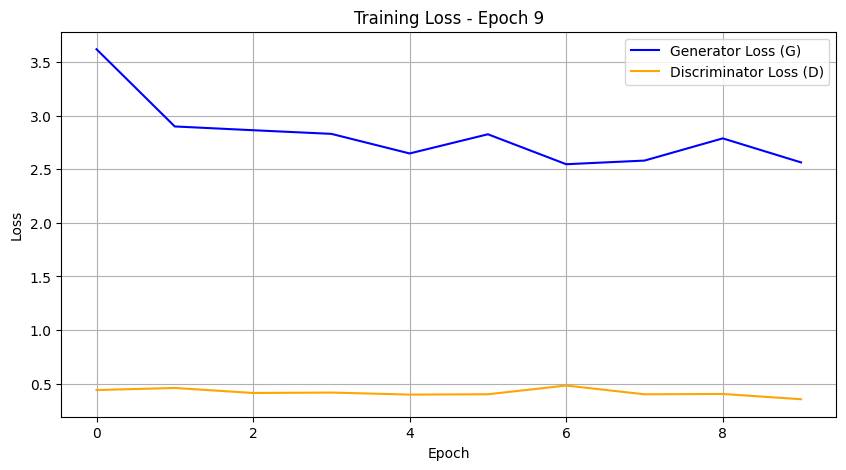

💾 Model tersimpan di akhir Epoch 9
📊 Stats: G_Loss=2.5641 | D_Loss=0.3533


In [7]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output  # Untuk update grafik secara live

# --- 1. SETUP VARIABEL LOSS ---
# Cek apakah variabel sudah ada (supaya kalau resume, grafik lama tidak hilang)
if 'G_losses' not in globals(): G_losses = []
if 'D_losses' not in globals(): D_losses = []

# --- 2. LOAD MODEL TERAKHIR (SAFETY) ---
try:
    print("Memuat model terakhir...")
    # Pastikan file .pth ada sebelum diload
    if os.path.exists('G_photo2cartoon.pth'):
        G_AB.load_state_dict(torch.load('G_photo2cartoon.pth', map_location=device))
        print("✅ Lanjut training dari checkpoint terakhir!")
    else:
        print("⚠️ File checkpoint tidak ditemukan, mulai dari awal (atau memory lama).")
except Exception as e:
    print(f"Info: {e}")

# --- 3. TRAINING LOOP DENGAN LIVE GRAPH ---
# Ubah range sesuai kebutuhan (misal sisa 7 epoch lagi)
for epoch in range(10): 
    g_epoch = 0
    d_epoch = 0 # Tambahan variabel untuk rata-rata Loss Discriminator
    
    # Setup Loading Bar
    loop = tqdm(dl, desc=f"Epoch {epoch}/10")
    
    for realA, realB in loop:
        realA, realB = realA.to(device), realB.to(device)

        # --- A. TRAIN GENERATOR ---
        fakeB = G_AB(realA)
        fakeA = G_BA(realB)
        recA = G_BA(fakeB)
        recB = G_AB(fakeA)
        
        loss_id = identity(G_AB(realB), realB)*5 + identity(G_BA(realA), realA)*5
        loss_cycle = cycle(recA, realA)*10 + cycle(recB, realB)*10
        loss_gan = gan(D_B(fakeB), torch.ones_like(D_B(fakeB))) + gan(D_A(fakeA), torch.ones_like(D_A(fakeA)))
        
        loss_G = loss_id + loss_cycle + loss_gan
        opt_G.zero_grad(); loss_G.backward(); opt_G.step()
        
        # --- B. TRAIN DISCRIMINATOR ---
        loss_D = (gan(D_A(realA), torch.ones_like(D_A(realA))) + gan(D_A(fakeA.detach()), torch.zeros_like(D_A(fakeA))) + 
                  gan(D_B(realB), torch.ones_like(D_B(realB))) + gan(D_B(fakeB.detach()), torch.zeros_like(D_B(fakeB)))) * 0.5
        
        opt_D.zero_grad(); loss_D.backward(); opt_D.step()
        
        # --- C. RECORD DATA ---
        g_epoch += loss_G.item()
        d_epoch += loss_D.item() # Catat loss D

        # Update angka loss di loading bar (Live Validation)
        loop.set_postfix(G_loss=loss_G.item(), D_loss=loss_D.item())

    # --- SETIAP AKHIR EPOCH ---
    
    # 1. Simpan Rata-rata Loss Epoch ini
    avg_G_loss = g_epoch/len(dl)
    avg_D_loss = d_epoch/len(dl)
    G_losses.append(avg_G_loss)
    D_losses.append(avg_D_loss)

    # 2. Save Model Otomatis
    torch.save(G_AB.state_dict(), 'G_photo2cartoon.pth')
    
    # 3. UPDATE GRAFIK (LIVE PLOT)
    clear_output(wait=True) # Hapus output lama
    
    plt.figure(figsize=(10, 5))
    plt.title(f"Training Loss - Epoch {epoch}")
    plt.plot(G_losses, label="Generator Loss (G)", color="blue")
    plt.plot(D_losses, label="Discriminator Loss (D)", color="orange")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"💾 Model tersimpan di akhir Epoch {epoch}")
    print(f"📊 Stats: G_Loss={avg_G_loss:.4f} | D_Loss={avg_D_loss:.4f}")

In [8]:
# --- EMERGENCY SAVE ---
# Kode ini menyelamatkan progress yang ada di memori RAM ke Hardisk
try:
    torch.save(G_AB.state_dict(), 'G_photo2cartoon_emergency.pth')
    print("✅ AMAN! Model berhasil diselamatkan dengan nama 'G_photo2cartoon_emergency.pth'")
except NameError:
    print("❌ Gawat, variabel model hilang. Apakah kamu tidak sengaja restart kernel?")

✅ AMAN! Model berhasil diselamatkan dengan nama 'G_photo2cartoon_emergency.pth'


## Inference – Upload ANY Image (NO RETRAINING)

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

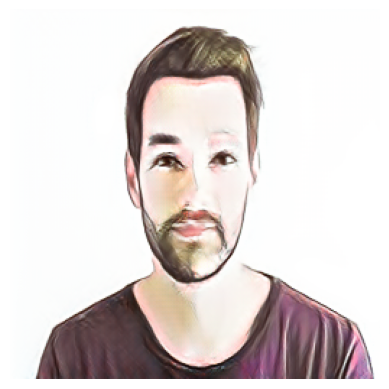

In [7]:
img_path = 'Untitled.jpg'

img = Image.open(img_path).convert('RGB').resize((256,256))
tf = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

G_AB.load_state_dict(torch.load('G_photo2cartoon.pth', map_location=device))
G_AB.eval()

with torch.no_grad():
    out = G_AB(tf(img).unsqueeze(0).to(device))[0]

out = (out.cpu()*0.5+0.5).permute(1,2,0).numpy()
plt.imshow(out); plt.axis('off')

In [8]:
import os

filename = 'G_photo2cartoon.pth'

# Cek apakah file sudah terbentuk di folder projectmu
if os.path.exists(filename):
    print(f"✅ HORE! File model '{filename}' sudah berhasil tersimpan di laptopmu.")
    print(f"Lokasinya ada di: {os.getcwd()}")
else:
    print(f"❌ File '{filename}' belum ditemukan. Sepertinya training belum selesai atau error.")

✅ HORE! File model 'G_photo2cartoon.pth' sudah berhasil tersimpan di laptopmu.
Lokasinya ada di: d:\Program Files\Kecerdasan Buatan\FPTugasGAN


Processing image: Untitled.jpg
Model weights loaded successfully.


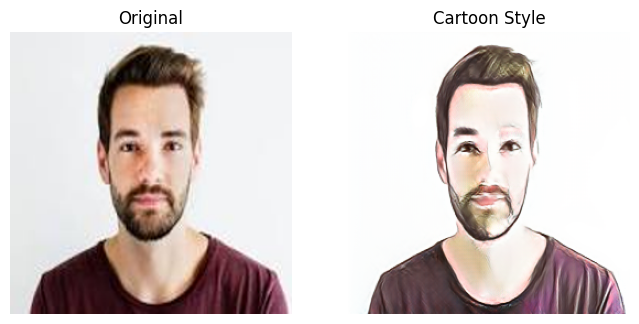

In [9]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

# 1. Define the specific path to your image
img_path = 'Untitled.jpg'

# Check if the image actually exists there
if not os.path.exists(img_path):
    print(f"ERROR: The image was not found at {img_path}")
    print("Please ensure you have uploaded the image to the main Colab content folder.")
else:
    print(f"Processing image: {img_path}")

    # 2. Load and Preprocess image
    # Resize to 256x256 matches typical CycleGAN training size
    img = Image.open(img_path).convert('RGB').resize((256, 256))

    # Define the same normalization used during training (-1 to 1 range)
    tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # 3. Load pre-trained weights
    # Ensure G_AB is already defined from your training cells!
    if 'G_AB' not in globals():
        print("ERROR: Generator 'G_AB' is not defined. Run your model definition cells first.")
    else:
        try:
            # map_location ensures weights load even if you switched from GPU back to CPU
            G_AB.load_state_dict(torch.load('G_photo2cartoon.pth', map_location=device))
            print("Model weights loaded successfully.")

            # Set to evaluation mode (crucial for layers like BatchNorm/Dropout)
            G_AB.eval()

            # 4. Run Inference
            with torch.no_grad():
                # Preprocess -> Add batch dim (unsqueeze) -> Send to device -> Run model -> Get first result ([0])
                input_tensor = tf(img).unsqueeze(0).to(device)
                out_tensor = G_AB(input_tensor)[0]

            # 5. Post-process and Display
            # Denormalize from (-1, 1) back to (0, 1) range
            out_img = (out_tensor.cpu() * 0.5 + 0.5)
            # Rearrange dimensions from pytorch (C,H,W) to matplotlib (H,W,C)
            out_img = out_img.permute(1, 2, 0).numpy()

            plt.figure(figsize=(8,4))

            plt.subplot(1,2,1)
            plt.title("Original")
            plt.imshow(img)
            plt.axis('off')

            plt.subplot(1,2,2)
            plt.title("Cartoon Style")
            plt.imshow(out_img)
            plt.axis('off')

            plt.show()

        except FileNotFoundError:
            print("ERROR: 'G_photo2cartoon.pth' not found. Make sure you have trained and saved the model weights.")